# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.special import erf
from scipy.special import erfinv
from scipy.spatial import ConvexHull
from astropy.io import fits
from time import time as time

from numba import njit
from photutils import segmentation as segm

import fabada as f

## 2. Read data

### select one dataset:

In [2]:
dataset = 2

In [68]:
plots = True

In [4]:
plots = False

1D spectra

2D images:

In [5]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [6]:
if dataset == 2:
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

3D datacubes:

In [7]:
if dataset == 3:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


In [8]:
if dataset == 4:
    hdu = fits.open('data/sofiawsrtcube.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

In [9]:
data_dimensionality = len(data.shape)

In [10]:
if plots and data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    dmin, dmed, dmax = np.nanpercentile(data, [16, 50, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower', cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=dmin, linthresh=dmed-dmin, vmax=dmax),
                  )
    ax.set_title('Input data')
    cb = fig.colorbar(im, ax=ax)
    plt.show()

In [11]:
if plots and data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    #lo = np.nanpercentile(data, 70)
    #hi = np.nanpercentile(data, 99)
    lo = -.1
    hi = .1
    rms = np.sqrt(np.nanmean(data**2))
    #colour_scale = colors.SymLogNorm(vmin=0, linthresh=rms/np.sqrt(np.mean(data.shape)), vmax=np.nanmax(data))
    colour_scale = colors.SymLogNorm(vmin=0, linthresh=1, vmax=10)
    
    im = ax[0, 0].imshow(np.sqrt(np.nanmean(data**2, axis=0))/rms-1,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                         vmin=lo, vmax=hi,
                  )
    ax[0, 0].set_title('Input data (rms value along specral axis)')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(data**2, axis=2)).T/rms-1,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                         vmin=lo, vmax=hi,
                  )
    #ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(data**2, axis=1))/rms-1,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                         vmin=lo, vmax=hi,
                  )
    #ax[1, 0].set_aspect('auto')
    
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    cb = fig.colorbar(im, ax=ax[1, 1])
    ax[1, 1].set_visible(False)
    plt.show()

## 3. Find mode

### number density and cumulative fraction:

In [12]:
t0 = time()
flat_data = data.ravel()
dummy_argsort = np.argsort(flat_data, axis=None)
number_fraction = (np.arange(data.size)+0.5)/data.size
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.1284637451171875 s


I had to downsaple, both for smoothing as well as to avoid numerical problems (CPU time, and even crashes due to the memory required by the plots) 

In [13]:
d50 = flat_data[dummy_argsort[data.size//2]]
print(f'Data median: {d50:.3g}')
bg_std = np.sqrt(np.mean((flat_data[dummy_argsort[:data.size//2]] - d50)**2))
print(f'First guess of background standard deviation: {bg_std:.3g}')

d_left = flat_data[dummy_argsort[1]]
d_right = d50 + 2*(d50-d_left)
n_steps = int(100*(d_right-d_left)/bg_std)
data_sample = np.linspace(d_left, d_right, n_steps)
print(f'Data subsampled to {n_steps} linear steps between {d_left:.3g} and {d_right:.3g}')

Data median: 0.000786
First guess of background standard deviation: 0.0013
Data subsampled to 1311 linear steps between -0.0049 and 0.0122


Smooth density field (boxcar with $h=\sigma_{bg}$, i.e. between $x \pm \frac{\sigma_{bg}}{2}$):

In [14]:
t0 = time()
h_smooth = bg_std
m_left = np.interp(data_sample-h_smooth/2, flat_data[dummy_argsort], number_fraction)
m_right = np.interp(data_sample+h_smooth/2, flat_data[dummy_argsort], number_fraction)
data_sample_rho_smooth = (m_right-m_left) / h_smooth
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.012628793716430664 s


### density mode:

Naive method:

In [15]:
t0 = time()
data_mode = data_sample[np.argmax(data_sample_rho_smooth)]
print(f'Naive mode:{data_mode:.3g}')
print(f'time elapsed: {time()-t0} s')

Naive mode:0.000439
time elapsed: 0.0006518363952636719 s


More stable:

In [16]:
t0 = time()
weight = data_sample_rho_smooth**10
data_mode = np.sum(data_sample*weight) / np.sum(weight)
print(f'More stable:{data_mode:.3g}')
print(f'time elapsed: {time()-t0} s')

More stable:0.000467
time elapsed: 0.0009992122650146484 s


In [17]:
t0 = time()
bg_std = np.sqrt(np.mean((flat_data[flat_data < data_mode] - data_mode)**2))
print(f'background std={bg_std:.3g}')
print(f'time elapsed: {time()-t0} s')

background std=0.00116
time elapsed: 0.007244110107421875 s


## 4. Signal / background classification

### compute probability:

Asumming that the background intensity is symmetric around $I_0$, which is well traced by the mode,
$$ p_{bg}(I > I_0) = \frac{p(2I_0-I)}{p(I)} ~~;~~ p_{src} = 1 - p_{bg}$$

In [18]:
t0 = time()
rho_sym = np.interp(2*data_mode-data_sample, data_sample, data_sample_rho_smooth, left=0)
probability_bg = np.clip(rho_sym/data_sample_rho_smooth, 0, 1)
dummy_src_probability_map = 1 - np.interp(data, data_sample, probability_bg)
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.06164741516113281 s


### estimate threshold:

a) The number of background pixels is the same above and below mode:

In [19]:
t0 = time()
N_mode = np.count_nonzero(data < data_mode)
N_src = np.sum(dummy_src_probability_map)
N_background = data.size - N_src
print(f'{N_mode} ({100*N_mode/data.size:.1f}%) pixels below mode')
print(f'{N_background} ({100*N_background/data.size:.1f}%) background pixels; N_background/N_mode={N_background/N_mode}')
print(f'{data.size-N_background} ({100-100*N_background/data.size:.1f}%) source pixels; N_pixels-2N_mode={data.size-2*N_mode}')

number_threshold = flat_data[dummy_argsort[int(N_background)]]
print(f'Number-based threshold={number_threshold:.3g}, ({(number_threshold-data_mode)/bg_std:.3g} sigmas)')
print(f'time elapsed: {time()-t0} s')

412351 (41.2%) pixels below mode
826566.3166398421 (82.7%) background pixels; N_background/N_mode=2.0045211885986505
173433.68336015788 (17.3%) source pixels; N_pixels-2N_mode=175298
Number-based threshold=0.00282, (2.02 sigmas)
time elapsed: 0.002514362335205078 s


b) The background flux is the same:

In [20]:
t0 = time()
total_flux_below_mode = np.sum(data_mode-flat_data[flat_data < data_mode])
flux_above_mode = np.cumsum(flat_data[dummy_argsort[N_mode:]]-data_mode)
flux_threshold = np.interp(total_flux_below_mode, flux_above_mode, flat_data[dummy_argsort[N_mode:]])
print(f'Total flux: {total_flux_below_mode:.3g} below mode, {flux_above_mode[-1]:.3g} above')
print(f'Flux-based threshold={flux_threshold:.3g} ({(flux_threshold-data_mode)/bg_std:.3g} sigmas)')
print(f'time elapsed: {time()-t0} s')

Total flux: 383 below mode, 1.31e+04 above
Flux-based threshold=0.00289 (2.08 sigmas)
time elapsed: 0.017999887466430664 s


c) Below the mode, $p_{src}$ and $p_{bg}$ should be zero and one, respectively. The maximum difference found sets the (un)reliable regime:

In [21]:
t0 = time()
reliable_bg_probability = np.min(probability_bg[data_sample < data_mode])
reliable_src_probability = 1 - reliable_bg_probability
probability_threshold = np.min(data_sample[probability_bg < reliable_bg_probability])
print(f'Reliable probabilities: p_src > {reliable_src_probability:.3g}; p_bg < {reliable_bg_probability:.3g}')
print(f'Probability-based threshold={probability_threshold:.3g} ({(probability_threshold-data_mode)/bg_std:.3g} sigmas)')
print(f'time elapsed: {time()-t0} s')

Reliable probabilities: p_src > 0.0054; p_bg < 0.995
Probability-based threshold=0.00127 (0.694 sigmas)
time elapsed: 0.00040078163146972656 s


Now, take the minimum of three:

In [22]:
threshold_guess = min([number_threshold, flux_threshold, probability_threshold])
delta_th = (threshold_guess - data_mode) / bg_std

In [23]:
colour_scale = colors.SymLogNorm(vmin=d_left, linthresh=threshold_guess, vmax=np.nanmax(data))

### summary plot:

In [24]:
if plots:
    plt.close('density')
    fig = plt.figure('density')
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(data_mode, c='k', ls=':')
        shade = axis.fill_between(data_sample, 0, 1, where=np.abs(data_sample-data_mode) <= bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={data_mode:.3g}, bg_std={bg_std:.3g}')
        th_line = axis.axvline(threshold_guess, c='k', ls='--')
    fig.set_tight_layout(True)

    ax[0, 0].set_ylabel('density')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(data_sample_rho_smooth[data_sample > data_mode]), 2*np.max(data_sample_rho_smooth))
    ax[0, 0].plot(data_sample, data_sample_rho_smooth, 'k+')
    ax[0, 0].plot(data_sample,
                  np.exp(-.5*((data_sample-data_mode)/bg_std)**2) * N_background/data.size/np.sqrt(2*np.pi)/bg_std,
                  'k:', label='Gaussian')
    ax[0, 0].plot(data_sample, rho_sym, 'r--', label='symmetric')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('probability')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(reliable_src_probability, 1.5)
    ax[1, 0].plot(data_sample, probability_bg, 'r-',
                  label=f'{N_background:.1f} "background" values ({100*N_background/data.size:.1f}%)')
    ax[1, 0].plot(data_sample, 1-probability_bg, 'b-',
                  label=f'{data.size-N_background:.1f} "signal" values ({100-100*N_background/data.size:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {threshold_guess:.3g} ({delta_th:.3g} sigmas)')
    ax[1, 0].legend()

    ax[-1, 0].set_xlabel('data value')


## 5. Noise reduction (FABADA)

In [25]:
#smoothed_data = f.fabada(data, bg_std**2, verbose=True)
#smoothed_data = data

In [32]:
#@njit
def fabada_filter(data, noise_std, max_iter=50):
    '''
    '''
    strides = np.array(data.strides)//data.itemsize
    flat_data = data.ravel()
    filtered_data = np.copy(flat_data)
    weighted_sum = np.empty(data.size, dtype=data.dtype)
    total_weight = np.empty(data.size, dtype=np.float32)
    expected_max_residual = erfinv(1-2/data.size)*np.sqrt(2)    

    iteration = 0
    while iteration < max_iter:
        t0 = time()
        np.copyto(weighted_sum, filtered_data)
        total_weight.fill(1.)
        for stride in strides:
            weight = np.exp(-.5*((filtered_data[:-stride]-filtered_data[stride:])/noise_std)**2)
            total_weight[:-stride] += weight
            total_weight[stride:] += weight
            weighted_sum[:-stride] += weight*filtered_data[stride:]
            weighted_sum[stride:] += weight*filtered_data[:-stride]
        filtered_data = weighted_sum / total_weight
        iteration += 1

        residual = (flat_data-filtered_data)/noise_std
        max_residual = np.max(residual)
        print(f'iteration {iteration} ({time()-t0} s):',
              f'residual std={np.sqrt(np.mean(residual**2)):.3g},',
              f'max={max_residual:.3g} (expected={expected_max_residual:.3g})')
        if max_residual > expected_max_residual:
            break
    
    return np.reshape(filtered_data, data.shape)

'''
'''
t0 = time()
smoothed_data = fabada_filter(data, bg_std)
print(f'time elapsed: {time()-t0} s')
hdu_out = fits.PrimaryHDU(smoothed_data)
hdu_out.writeto('smoothed_data.fits', overwrite=True)


iteration 1 (0.01666855812072754 s): residual std=0.354, max=0.847 (expected=4.75)
iteration 2 (0.013789176940917969 s): residual std=0.56, max=1.6 (expected=4.75)
iteration 3 (0.013907670974731445 s): residual std=0.687, max=2.2 (expected=4.75)
iteration 4 (0.02118372917175293 s): residual std=0.765, max=2.62 (expected=4.75)
iteration 5 (0.01593017578125 s): residual std=0.812, max=3.07 (expected=4.75)
iteration 6 (0.013346433639526367 s): residual std=0.843, max=3.29 (expected=4.75)
iteration 7 (0.026270151138305664 s): residual std=0.865, max=3.48 (expected=4.75)
iteration 8 (0.014245748519897461 s): residual std=0.882, max=3.64 (expected=4.75)
iteration 9 (0.01367330551147461 s): residual std=0.895, max=3.79 (expected=4.75)
iteration 10 (0.015449762344360352 s): residual std=0.907, max=4.05 (expected=4.75)
iteration 11 (0.013294219970703125 s): residual std=0.917, max=4.37 (expected=4.75)
iteration 12 (0.012543439865112305 s): residual std=0.925, max=4.53 (expected=4.75)
iteration 

In [33]:
if plots:
    plt.close('filter_plot')
    fig = plt.figure('filter_plot', figsize=(5, 4))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    delta_dummy = np.linspace(-5, 5, 101)
    expected_above_delta = .5*(1 - erf(delta_dummy/np.sqrt(2)))
    ax[0, 0].plot(delta_dummy, np.exp(-.5*delta_dummy**2)/np.sqrt(2*np.pi), 'k--')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(1/data.size, 2)
#    ax[1, 0].plot(delta_dummy, expected_above_delta, 'k--')
#    ax[1, 0].set_yscale('log')
    ax[-1, 0].set_xlabel('$\Delta$ = (Input - Filtered) / $\sigma$')
    ax[-1, 0].set_xlim(-5, 5)

    delta = (data.ravel()-smoothed_data.ravel())/bg_std
    ax[0, 0].hist(delta, bins=delta_dummy, density=True, color='b', alpha=.5)
    #ax[1, 0].plot(delta[sorted_by_delta[::1000]], observed_above_delta[::1000], 'k-', alpha=iteration/max_iter)
    #ax[2, 0].plot(delta[sorted_by_delta], observed_above_delta/expected, 'k-', alpha=iteration/max_iter)


In [34]:
t0 = time()
flat_smoothed_data = smoothed_data.ravel()
#argsort_smoothed_data_ravel = np.argsort(flat_smoothed_data, axis=None)
dummy_argsort = np.argsort(flat_smoothed_data, axis=None)  # recycle variable (TODO: look for a name that avoids confusion)
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.108642578125 s


I had to downsaple, both for smoothing as well as to avoid numerical problems (CPU time, and even crashes due to the memory required by the plots) 

In [35]:
t0 = time()
d50 = flat_smoothed_data[dummy_argsort[data.size//2]]
print(f'Data median: {d50:.3g}')
smoothed_bg_std = np.sqrt(np.mean((flat_smoothed_data[dummy_argsort[:data.size//2]]-d50)**2))
print(f'First guess of background standard deviation: {smoothed_bg_std:.3g}')

d_left = flat_smoothed_data[dummy_argsort[1]]
d_right = d50 + 2*(d50-d_left)
n_steps = int(100*(d_right-d_left)/bg_std)
smoothed_data_sample = np.linspace(d_left, d_right, n_steps)
print(f'Smoothed data subsampled to {n_steps} linear steps between {d_left:.3g} and {d_right:.3g}')
print(f'time elapsed: {time()-t0} s')

Data median: 0.000543
First guess of background standard deviation: 0.000401
Smoothed data subsampled to 1295 linear steps between -0.00447 and 0.0106
time elapsed: 0.0036711692810058594 s


Smooth density field (boxcar with $h=\sigma_{bg}$, i.e. between $x \pm \frac{\sigma_{bg}}{2}$):

In [36]:
t0 = time()
h_smooth = smoothed_bg_std
m_left = np.interp(smoothed_data_sample-h_smooth/2, flat_smoothed_data[dummy_argsort], number_fraction)
m_right = np.interp(smoothed_data_sample+h_smooth/2, flat_smoothed_data[dummy_argsort], number_fraction)
smoothed_data_sample_rho_smooth = (m_right-m_left) / h_smooth
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.014025688171386719 s


### density mode:

Naive method:

In [37]:
smoothed_data_mode = smoothed_data_sample[np.argmax(smoothed_data_sample_rho_smooth)]
print(f'Naive mode:{smoothed_data_mode:.3g}')

Naive mode:0.000294


More stable:

In [38]:
weight = smoothed_data_sample_rho_smooth**10
smoothed_data_mode = np.sum(smoothed_data_sample*weight) / np.sum(weight)
print(f'More stable:{smoothed_data_mode:.3g}')

More stable:0.000293


In [39]:
t0 = time()
smoothed_bg_std = np.sqrt(np.mean((flat_smoothed_data[flat_smoothed_data < smoothed_data_mode]- smoothed_data_mode)**2))
print(f'background std={smoothed_bg_std:.3g}')
print(f'time elapsed: {time()-t0} s')

background std=0.000272
time elapsed: 0.003092527389526367 s


## 6. New signal / background classification

### compute probability:

Asumming that the background intensity is symmetric around $I_0$, which is well traced by the mode,
$$ p_{bg}(I > I_0) = \frac{p(2I_0-I)}{p(I)} ~~;~~ p_{src} = 1 - p_{bg}$$

In [40]:
t0 = time()
rho_sym = np.interp(2*smoothed_data_mode-smoothed_data_sample, smoothed_data_sample, smoothed_data_sample_rho_smooth, left=0)
smoothed_probability_bg = np.clip(rho_sym/smoothed_data_sample_rho_smooth, 0, 1)
dummy_src_probability_map = 1 - np.interp(smoothed_data, smoothed_data_sample, smoothed_probability_bg)
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.037181854248046875 s


### estimate threshold:

a) The number of background pixels is the same above and below mode:

In [41]:
t0 = time()
N_mode = np.count_nonzero(smoothed_data < smoothed_data_mode)
N_src = np.sum(dummy_src_probability_map)
N_background = smoothed_data.size-N_src
print(f'{N_mode} ({100*N_mode/data.size:.1f}%) pixels below mode')
print(f'{N_background} ({100*N_background/data.size:.1f}%) background pixels; N_background/N_mode={N_background/N_mode}')
print(f'{data.size-N_background} ({100-100*N_background/data.size:.1f}%) source pixels; N_pixels-2N_mode={data.size-2*N_mode}')

number_threshold = flat_data[dummy_argsort[int(N_background)]]
print(f'Number-based threshold={number_threshold:.3g}, ({(number_threshold-smoothed_data_mode)/bg_std:.3g} sigmas)')
print(f'time elapsed: {time()-t0} s')

310904 (31.1%) pixels below mode
620096.7310991219 (62.0%) background pixels; N_background/N_mode=1.9944958286130827
379903.26890087815 (38.0%) source pixels; N_pixels-2N_mode=378192
Number-based threshold=0.00243, (1.84 sigmas)
time elapsed: 0.00222015380859375 s


b) The background flux is the same:

In [42]:
t0 = time()
total_flux_below_mode = np.sum(smoothed_data_mode-flat_smoothed_data[flat_smoothed_data < smoothed_data_mode])
flux_above_mode = np.cumsum(flat_smoothed_data[dummy_argsort[N_mode:]]-smoothed_data_mode)
flux_threshold = np.interp(total_flux_below_mode, flux_above_mode, flat_smoothed_data[dummy_argsort[N_mode:]])
print(f'Total flux: {total_flux_below_mode:.3g} below mode, {flux_above_mode[-1]:.3g} above')
print(f'Flux-based threshold={flux_threshold:.3g} ({(flux_threshold-smoothed_data_mode)/bg_std:.3g} sigmas)')
print(f'time elapsed: {time()-t0} s')

Total flux: 67.7 below mode, 1.3e+04 above
Flux-based threshold=0.000799 (0.436 sigmas)
time elapsed: 0.01362299919128418 s


c) Below the mode, $p_{src}$ and $p_{bg}$ should be zero and one, respectively. The maximum difference found sets the (un)reliable regime:

In [43]:
reliable_bg_probability = np.min(smoothed_probability_bg[smoothed_data_sample < smoothed_data_mode])
reliable_src_probability = 1 - reliable_bg_probability
probability_threshold = np.min(smoothed_data_sample[smoothed_probability_bg < reliable_bg_probability])
print(f'Reliable probabilities: p_src > {reliable_src_probability:.3g}; p_bg < {reliable_bg_probability:.3g}')
print(f'Probability-based threshold={probability_threshold:.3g} ({(probability_threshold-smoothed_data_mode)/bg_std:.3g} sigmas)')

Reliable probabilities: p_src > 0.016; p_bg < 0.984
Probability-based threshold=0.000515 (0.191 sigmas)


Now, take the minimum of three:

In [44]:
#smoothed_threshold_guess = probability_threshold
smoothed_threshold_guess = min([number_threshold, flux_threshold, probability_threshold])

### summary plot:

In [45]:
if plots:
    plt.close('smoothed_density')
    fig = plt.figure('smoothed_density')
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(smoothed_data_mode, c='k', ls=':')
        shade = axis.fill_between(smoothed_data_sample, 0, 1, where=np.abs(smoothed_data_sample-smoothed_data_mode) <= smoothed_bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={smoothed_data_mode:.3g}, bg_std={smoothed_bg_std:.3g}')
        th_line = axis.axvline(threshold_guess, c='k', ls='--')
        smoothed_th_line = axis.axvline(smoothed_threshold_guess, c='k', ls='-.')
    fig.set_tight_layout(True)

    ax[0, 0].set_ylabel('density')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(smoothed_data_sample_rho_smooth[smoothed_data_sample > smoothed_data_mode]), 2*np.max(smoothed_data_sample_rho_smooth))
    ax[0, 0].plot(smoothed_data_sample, smoothed_data_sample_rho_smooth, 'k+')
    ax[0, 0].plot(smoothed_data_sample,
                  np.exp(-.5*((smoothed_data_sample-smoothed_data_mode)/smoothed_bg_std)**2) * N_background/data.size/np.sqrt(2*np.pi)/smoothed_bg_std,
                  'k:', label='Gaussian')
    ax[0, 0].plot(smoothed_data_sample, rho_sym, 'r--', label='symmetric')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('probability')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(reliable_src_probability, 1.5)
    ax[1, 0].plot(smoothed_data_sample, smoothed_probability_bg, 'r-',
                  label=f'{N_background:.1f} "background" values ({100*N_background/data.size:.1f}%)')
    ax[1, 0].plot(smoothed_data_sample, 1-smoothed_probability_bg, 'b-',
                  label=f'{data.size-N_background:.1f} "signal" values ({100-100*N_background/data.size:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {threshold_guess:.3g} ({delta_th:.3g} sigmas)')
    smoothed_th_line.set_label(f'smoothed threshold: {smoothed_threshold_guess:.3g} ({(smoothed_threshold_guess-smoothed_data_mode)/bg_std:.3g}) sigmas')
    ax[1, 0].legend()

    ax[-1, 0].set_xlabel('smoothed data value')


In [46]:
if plots and data_dimensionality == 2:
    plt.close('bg_map')
    fig = plt.figure('bg_map', figsize=(10, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 0].contour(smoothed_data, levels=[smoothed_threshold_guess, threshold_guess], colors=['w', 'k'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(threshold_guess, c='k', ls='--')
    cb.ax.axhline(data_mode, c='k', ls=':')

    ax[0, 1].set_title('Source probability map')
    im = ax[0, 1].imshow(
        dummy_src_probability_map,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        norm = colors.SymLogNorm(vmin=0, linthresh=reliable_src_probability, vmax=1),
        )
    ax[0, 1].contour(smoothed_data, levels=[smoothed_threshold_guess, threshold_guess], colors=['w', 'k'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(reliable_src_probability, c='k', ls='--')

    ax[1, 0].set_title('Smoothed data')
    im = ax[1, 0].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[1, 0].contour(smoothed_data, levels=[smoothed_threshold_guess, threshold_guess], colors=['w', 'k'])
    cb = fig.colorbar(im, ax=ax[1, 0])
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    cb.ax.axhline(smoothed_data_mode, c='k', ls=':')

    ax[1, 1].set_title('Smoothed source probability map')
    im = ax[1, 1].imshow(
        dummy_src_probability_map,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        norm = colors.SymLogNorm(vmin=0, linthresh=reliable_src_probability, vmax=1),
        )
    ax[1, 1].contour(smoothed_data, levels=[smoothed_threshold_guess, threshold_guess], colors=['w', 'k'])
    cb = fig.colorbar(im, ax=ax[1, 1])
    cb.ax.axhline(reliable_src_probability, c='k', ls='--')


## 7. Hierarchical Overdensity Tree (HOT)

### routine definition:

$$ S = \sum p_i (I_i - I_0) $$
$$ \sigma^2 = 2\sigma_0^2 \sum p_i $$

$$ n = \sum p_i $$
$$ \Delta S_n = p_n I_n + (n-1) I_{n-1} - n I_n = (p_n - 1) I_n + (n-1) (I_{n-1}-I_n) $$
$$ \Delta S_n > 0 ~~ \iff ~~ I_n < \frac{n-1}{1-p_n} I_{n-1} ~;~ 1-p_n < (n-1) \frac{I_{n-1}}{I_n} $$

$$ \Delta \sigma^2_i = p_i 2\sigma_0^2 $$

$$ \Delta \ln(S/N)^2 \sim \frac{(S+\Delta S)^2}{\sigma^2 + \Delta \sigma^2 } \frac{\sigma^2}{S^2} $$
$$ \propto \frac{S^2+p^2I^2+2pI}{1 + p } $$

$$
(S/N)^2_{a+b} = \frac{ (S_a + S_b)^2 }{ \sigma^2_a + \sigma^2_b }
= \frac{ \sigma^2_a\frac{S^2_a}{\sigma^2_a} + \sigma^2_b\frac{S^2_b}{\sigma^2_b}
        + 2 \sigma_a\sigma_b\frac{S_a}{\sigma_a}\frac{S_b}{\sigma_b} }{ \sigma^2_a + \sigma^2_b }
$$ 

In [47]:
#HOT_threshold = np.sqrt((smoothed_threshold_guess-smoothed_data_mode) * (threshold_guess-data_mode))
#HOT_threshold = ((smoothed_threshold_guess-smoothed_data_mode) + (threshold_guess-data_mode)) / 2
HOT_threshold = smoothed_threshold_guess-smoothed_data_mode
#HOT_threshold = threshold_guess-data_mode

In [48]:
smoothed_threshold_guess, threshold_guess, HOT_threshold

(0.0005153953595719574, 0.001272232930232835, 0.0002221294649916841)

In [49]:
@njit
def hot(data, smoothed_data, argsort_smoothed_data_ravel, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    strides = np.array(data.strides)//data.itemsize
    flat_data = data.ravel()
    flat_smoothed_data = smoothed_data.ravel()
    
    label = np.zeros(data.size, dtype=np.int32)
    n_labels = 0
    n_peaks_max = 1 + data.size//2**len(strides)  # maximum number of peaks
    parent = np.zeros(n_peaks_max, dtype=np.int32)
    area = np.zeros(n_peaks_max, dtype=np.int32)
    sum_value = np.zeros(n_peaks_max, dtype=data.dtype)
    max_signal_to_noise = np.zeros(n_peaks_max, dtype=np.float32)
    signal_to_noise_area = np.zeros(n_peaks_max, dtype=np.int32)

    for pixel in argsort_smoothed_data_ravel[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        smoothed_pixel_value = flat_smoothed_data[pixel]
        if np.isnan(pixel_value):
            continue
        if smoothed_pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent

        label[pixel] = selected_parent
        area[selected_parent] += 1
        sum_value[selected_parent] += pixel_value
        n = area[selected_parent]
        signal_to_noise = (sum_value[selected_parent] - n*smoothed_pixel_value) / np.sqrt(n)
        if signal_to_noise > max_signal_to_noise[selected_parent]:
            max_signal_to_noise[selected_parent] = signal_to_noise
            signal_to_noise_area[selected_parent] = n
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_signal_to_noise[:n_labels+1],
               signal_to_noise_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### selection based on inverted image:

In [50]:
t0 = time()
label, catalog_inv = hot(smoothed_data_mode-data,
                         smoothed_data_mode-smoothed_data,
                         dummy_argsort[::-1],
                         HOT_threshold)
#parent_inv = catalog_inv[0]
#area_inv = catalog_inv[1]
max_signal_to_noise_inv = catalog_inv[2]
signal_to_noise_area_inv = catalog_inv[3]
print(f'time elapsed: {time()-t0} s')

3477 overdensities found: 130634 "pixels" (13%), 1291 independent regions
time elapsed: 3.0062522888183594 s


Compute the upper hull of the inverted catalogue:

In [51]:
t0 = time()


def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]

'''
good_hull = (signal_to_noise_area_inv > 0)
log_area_inv = np.log(signal_to_noise_area_inv[good_hull])
signal = max_signal_to_noise_inv[good_hull]
signal_hull_x, signal_hull_y = upper_hull(log_area_inv, signal)
'''
print(f'time elapsed: {time()-t0} s')

time elapsed: 0.00025177001953125 s


### analysis of the normal image:

In [52]:
t0 = time()
#label, catalog = hot((data-data_mode)/bg_std, dummy_argsort, HOT_threshold)
#label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, threshold_guess)
#label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, smoothed_threshold_guess)
label, catalog = hot(data-smoothed_data_mode,
                     smoothed_data-smoothed_data_mode,
                     dummy_argsort,
                     HOT_threshold)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_signal_to_noise = catalog[2]
signal_to_noise_area = catalog[3]
print(f'time elapsed: {time()-t0} s')

4118 overdensities found: 517267 "pixels" (51%), 865 independent regions
time elapsed: 1.2040669918060303 s


In [53]:
hist_SN_inv, bins = np.histogram(max_signal_to_noise_inv, density=True, bins='auto')
hist_SN, bins = np.histogram(max_signal_to_noise, bins=bins, density=True)
bins_SN = (bins[1:]+bins[:-1])/2
SN_threshold = np.max(bins_SN[hist_SN_inv > .5*hist_SN])
print(f'Maximum signal-to-noise threshold = {SN_threshold:.3g}')
print(f'time elapsed: {time()-t0} s')

Maximum signal-to-noise threshold = 0.00411
time elapsed: 1.2190790176391602 s


In [54]:
true_overdensity = max_signal_to_noise > SN_threshold

In [55]:
'''
true_overdensity = max_signal_to_noise > np.interp(np.log(signal_to_noise_area),
                                                   signal_hull_x, signal_hull_y, right=0)
true_overdensity |= max_signal_to_noise > SN_threshold
true_overdensity[0] = False
print(f'{np.count_nonzero(true_overdensity)} overdensities pass the selection criteria')
'''

"\ntrue_overdensity = max_signal_to_noise > np.interp(np.log(signal_to_noise_area),\n                                                   signal_hull_x, signal_hull_y, right=0)\ntrue_overdensity |= max_signal_to_noise > SN_threshold\ntrue_overdensity[0] = False\nprint(f'{np.count_nonzero(true_overdensity)} overdensities pass the selection criteria')\n"

In [56]:
if plots:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    '''
    #ax[1, 0].axhline(delta_th, c='k', ls=':')
    ax[1, 0].scatter(area[1:], max_value[1:]-min_value[1:], s=25, c='c')
    ax[1, 0].scatter(area[true_overdensity],
                     max_value[true_overdensity]-min_value[true_overdensity], s=1, c='k')
    ax[1, 0].plot(np.exp(contrast_hull_x), contrast_hull_y, 'y-*')
    ax[1, 0].scatter(area_inv[1:], max_value_inv[1:]-min_value_inv[1:], s=1, c='r')
    ax[1, 0].set_xscale('log')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(np.min(contrast_hull_y[contrast_hull_y > 0])/10)
    '''

    ax[0, 0].set_ylabel('maximum S/N')
    ax[0, 0].set_yscale('log')
    #ax[0, 0].set_ylim(1e-1*np.max(signal_hull_y), np.max(max_signal_to_noise))
    ax[0, 0].scatter(signal_to_noise_area[1:], max_signal_to_noise[1:], s=25, c='c')
    ax[0, 0].scatter(signal_to_noise_area_inv[1:], max_signal_to_noise_inv[1:], s=25, c='r')
    ax[0, 0].scatter(signal_to_noise_area[true_overdensity], max_signal_to_noise[true_overdensity], s=1, c='k')
    #ax[0, 0].scatter(signal_to_noise_area_inv[good_hull], max_signal_to_noise_inv[good_hull], s=5, c='y')
    #ax[0, 0].plot(np.exp(signal_hull_x), signal_hull_y, 'y*')
    #xx = np.linspace(signal_hull_x[0], signal_hull_x[-1], 100)
    #yy = np.interp(xx, signal_hull_x, signal_hull_y)
    #ax[0, 0].plot(np.exp(xx), yy, 'y-')
    ax[0, 0].axhline(SN_threshold, color='y', ls='--')

    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels at maximum S/N')

In [57]:
#sn_inv_sorted = np.sort(max_signal_to_noise_inv[1:])
#sn_sorted = np.sort(max_signal_to_noise[1:])

if plots:
    plt.close('SN_selection')
    fig = plt.figure('SN_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_xlabel('maximum S/N')
    #ax[0, 0].set_xscale('log')
    ax[0, 0].set_yscale('log')
    #ax[0, 0].plot(sn_sorted, np.arange(sn_sorted.size), 'b-')
    #ax[0, 0].plot(sn_inv_sorted, np.arange(sn_inv_sorted.size), 'r-')
    ax[0, 0].plot(bins_SN, hist_SN, color='b')
    ax[0, 0].plot(bins_SN, hist_SN_inv, color='r')
    ax[0, 0].axvline(SN_threshold, color='k', ls='--')
    


## 8. Clean-up

### prune HOT based on selection threshold

In [58]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

2711 yet to go
832 yet to go
571 yet to go
561 yet to go


In [59]:
if plots and data_dimensionality == 2:
    pruned_segmentation = segm.SegmentationImage(pruned_labels[label])
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        segmentation,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    ax[1, 0].set_title('Max S/N')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        max_signal_to_noise[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('S/N threshold')
    im = ax[1, 1].imshow(
        #saddle_value[label],
        signal_to_noise_threshold[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [60]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

1409 objects after mode filtering


In [61]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [71]:
if plots and data_dimensionality == 2:
    final_selection = segm.SegmentationImage(final_labels)
    final_cmap = final_selection.make_cmap(seed=123)
    final_catalog = segm.SourceCatalog(data, final_selection)
    final_catalog.to_table()

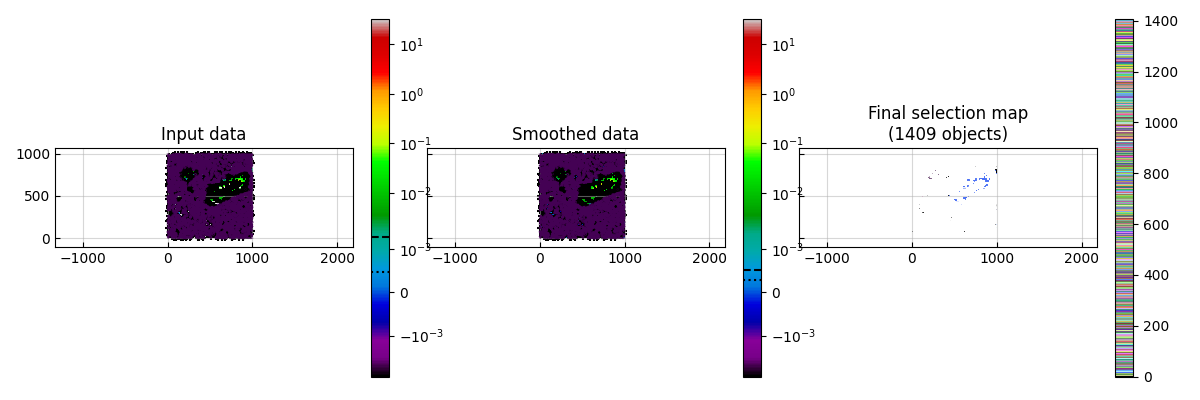

In [74]:
if plots and data_dimensionality == 2:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 0].contour(final_labels, levels=[0.5])
    #ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(data_mode, c='k', ls=':')
    cb.ax.axhline(threshold_guess, c='k', ls='--')
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')

    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    #ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_data_mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')

    ax[0, 2].set_title(f'Final selection map\n({n_final_labels} objects)')
    im = ax[0, 2].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    ax[0, 2].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='+')
    cb = fig.colorbar(im, ax=ax[0, 2])
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 2], color='white')


In [69]:
if plots and data_dimensionality == 3:
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-data_mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [65]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-data_mode)
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap=final_cmap,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap=final_cmap,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [66]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('HOT_labels.fits', overwrite=True)
'''
'''


'\n'

In [67]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('HOT_mask.fits', overwrite=True)
'''
'''


'\n'